# Fine-Tuning LLaMA 3.1 8B on MedMCQA Dataset
This notebook fine-tunes the `meta-llama/Llama-3.1-8B-Instruct` model on the `openlifescienceai/medmcqa` dataset using LoRA + Unsloth.

# Installing Libraries & Prerequisites

In [ ]:
%%capture
import os
# Add imports as desired

# Remove explicit torch and transformers installation as they are handled by subsequent installs
# and rely on pip to get the correct version for the system's CUDA setup.
# !pip install torch==2.3.0+cu118 -f https://download.pytorch.org/whl/torch_stable.html # Removed
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
# Install transformers and unsloth. Let unsloth handle this dependency.
!pip install transformers==4.51.3 # Removed
!pip install --no-deps unsloth

In [ ]:
from unsloth import FastLanguageModel
# import torch # Removed explicit torch import as unsloth handles it
max_seq_length = 256 # Choose any!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage.


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "meta-llama/Llama-3.1-8B-Instruct",       # Choose a model.
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

# ✅ Fix: Add LoRA adapters to enable fine-tuning on quantized model
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = True,
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.6.8: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Unsloth 2025.6.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


# Data Preprocessing

## Building a Function That can build the text column for the target

In [ ]:
def format_func(example):
    options = {
        "0": example["opa"],
        "1": example["opb"],
        "2": example["opc"],
        "3": example["opd"],
    }

    # Correct answer index as string
    correct_letter = str(example["cop"]).strip()
    correct_answer = options.get(correct_letter, "Unknown")

    key = {"0": "A", "1": "B", "2": "C", "3": "D"}
    answer_prefix = key.get(correct_letter, "")

    if answer_prefix:
        answer_part = f"Answer: {answer_prefix}. {correct_answer}"
    else:
        answer_part = f"Answer: {correct_answer}"

    # Retrieve explanation and ensure it's a string before stripping
    explanation_value = example.get("exp", "")
    explanation = str(explanation_value).strip() # Convert to string before stripping

    if explanation:
        explanation_part = f"Explanation: {explanation}"
    else:
        explanation_part = ""

    question_text = (
        f"<|user|>\n"
        f"Question: {example['question']}\n"
        f"A. {example['opa']}\n"
        f"B. {example['opb']}\n"
        f"C. {example['opc']}\n"
        f"D. {example['opd']}\n"
        f"<|assistant|>\n"
        f"{answer_part}\n"
        f"{explanation_part}"
    )

    example["text"] = question_text
    return example

## Applying the map function into entire the dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("openlifescienceai/medmcqa")

# Apply formatting
dataset = dataset.map(format_func)


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/85.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/936k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/182822 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6150 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4183 [00:00<?, ? examples/s]

Map:   0%|          | 0/182822 [00:00<?, ? examples/s]

Map:   0%|          | 0/6150 [00:00<?, ? examples/s]

Map:   0%|          | 0/4183 [00:00<?, ? examples/s]

In [ ]:
print(dataset['train'][1]['text'])
dataset['train'][1]

<|user|>
Question: Which vitamin is supplied from only animal source:
A. Vitamin C
B. Vitamin B7
C. Vitamin B12
D. Vitamin D
<|assistant|>
Answer: C. Vitamin B12
Explanation: Ans. (c) Vitamin B12 Ref: Harrison's 19th ed. P 640* Vitamin B12 (Cobalamin) is synthesized solely by microorganisms.* In humans, the only source for humans is food of animal origin, e.g., meat, fish, and dairy products.* Vegetables, fruits, and other foods of nonanimal origin doesn't contain Vitamin B12 .* Daily requirements of vitamin Bp is about 1-3 pg. Body stores are of the order of 2-3 mg, sufficient for 3-4 years if supplies are completely cut off.


{'id': 'e3d3c4e1-4fb2-45e7-9f88-247cc8f373b3',
 'question': 'Which vitamin is supplied from only animal source:',
 'opa': 'Vitamin C',
 'opb': 'Vitamin B7',
 'opc': 'Vitamin B12',
 'opd': 'Vitamin D',
 'cop': 2,
 'choice_type': 'single',
 'exp': "Ans. (c) Vitamin B12 Ref: Harrison's 19th ed. P 640* Vitamin B12 (Cobalamin) is synthesized solely by microorganisms.* In humans, the only source for humans is food of animal origin, e.g., meat, fish, and dairy products.* Vegetables, fruits, and other foods of nonanimal origin doesn't contain Vitamin B12 .* Daily requirements of vitamin Bp is about 1-3 pg. Body stores are of the order of 2-3 mg, sufficient for 3-4 years if supplies are completely cut off.",
 'subject_name': 'Biochemistry',
 'topic_name': 'Vitamins and Minerals',
 'text': "<|user|>\nQuestion: Which vitamin is supplied from only animal source:\nA. Vitamin C\nB. Vitamin B7\nC. Vitamin B12\nD. Vitamin D\n<|assistant|>\nAnswer: C. Vitamin B12\nExplanation: Ans. (c) Vitamin B12 Ref:

## Tokenizing the dataset - converting text into numbers the model understands.

In [ ]:
# Set your max length (LLaMA3 default is 2048 tokens)
MAX_LENGTH = 256

# Tokenize using the tokenizer from Unsloth
def tokenize_function(example):
    return tokenizer(
        example["text"],
        truncation=True,
        max_length=MAX_LENGTH,
        padding=False,  # Let batching handle padding
        return_tensors=None,
    )



# Then tokenize
tokenized_dataset = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/182822 [00:00<?, ? examples/s]

Map:   0%|          | 0/6150 [00:00<?, ? examples/s]

Map:   0%|          | 0/4183 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset["validation"][100]

{'id': 'e7f023ea-2147-47d3-9f2a-61fb60a900be',
 'question': 'Which of these drugs is an antidote for fibrinolytic therapy?',
 'opa': 'Epsilon aminocaproic acid',
 'opb': 'Protamine',
 'opc': 'Heparin',
 'opd': 'Streptokinase',
 'cop': 0,
 'choice_type': 'single',
 'exp': 'Answer- A. Epsilon aminocaproic acidEpsilon aminocaproic acid is an antidote for fibrinolytic therapy. Epsilon-aminocaproic qcid is a synthetic inhibitor of theplasmin-plasminogen system. It is the only potent antifibrinolylic agent, which is commercially available."Aminocaproic acid is a lysine analog that competes for lysine binding sites on plasminogen and plasmin, blocking theinteraction of plasmin with fibrin.Fibrinolytic overdose - Epsilon Amino Caproic Acid (EACA)',
 'subject_name': 'Pharmacology',
 'topic_name': None,
 'text': '<|user|>\nQuestion: Which of these drugs is an antidote for fibrinolytic therapy?\nA. Epsilon aminocaproic acid\nB. Protamine\nC. Heparin\nD. Streptokinase\n<|assistant|>\nAnswer: A. Ep

# Finding The Optimized Sequence for training

## Training Visulization

Tokenizing samples: 100%|██████████| 182822/182822 [02:46<00:00, 1096.60it/s]


🔢 Token Length Statistics:
Min: 44 tokens
Max: 5394 tokens
Mean: 184.33 tokens
90th Percentile: 333 tokens
95th Percentile: 435 tokens


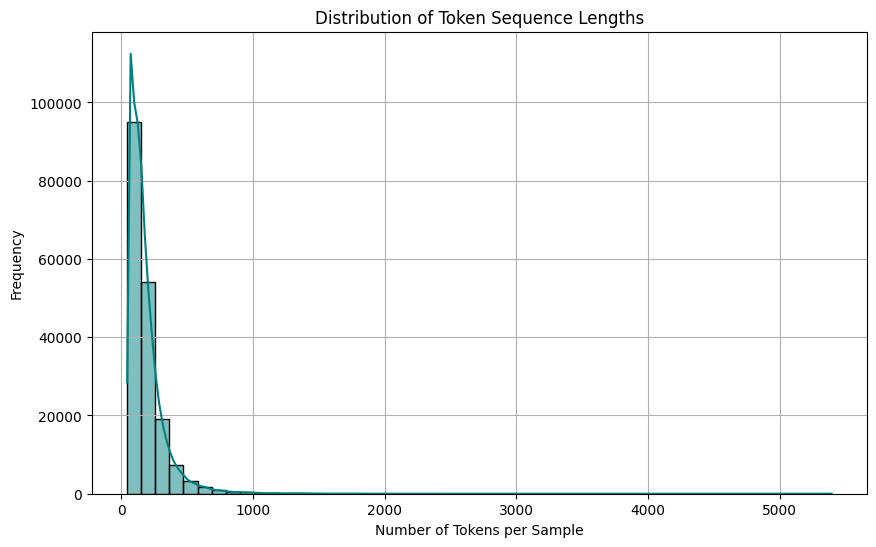

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from datasets import Dataset

# ⚠️ Replace with your dataset if needed
df = tokenized_dataset["train"]  # assumes HuggingFace Dataset format

# 🧮 Collect token lengths
token_lengths = []
# Iterate over the 'df' variable which holds the dataset split, not the string 'dataset'
for example in tqdm(df, desc="Tokenizing samples"):
    text = example["text"]
    tokens = tokenizer(text, truncation=False)["input_ids"]
    token_lengths.append(len(tokens))

# 📊 Basic statistics
min_len = np.min(token_lengths)
max_len = np.max(token_lengths)
mean_len = np.mean(token_lengths)
p90 = np.percentile(token_lengths, 90)
p95 = np.percentile(token_lengths, 95)

print(f"🔢 Token Length Statistics:")
print(f"Min: {min_len} tokens")
print(f"Max: {max_len} tokens")
print(f"Mean: {mean_len:.2f} tokens")
print(f"90th Percentile: {p90:.0f} tokens")
print(f"95th Percentile: {p95:.0f} tokens")

# 📈 Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(token_lengths, bins=50, kde=True, color="teal")
plt.title("Distribution of Token Sequence Lengths")
plt.xlabel("Number of Tokens per Sample")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Validation Visualization

Tokenizing samples: 100%|██████████| 4183/4183 [00:03<00:00, 1278.57it/s]


🔢 Token Length Statistics:
Min: 44 tokens
Max: 1020 tokens
Mean: 140.61 tokens
90th Percentile: 263 tokens
95th Percentile: 318 tokens


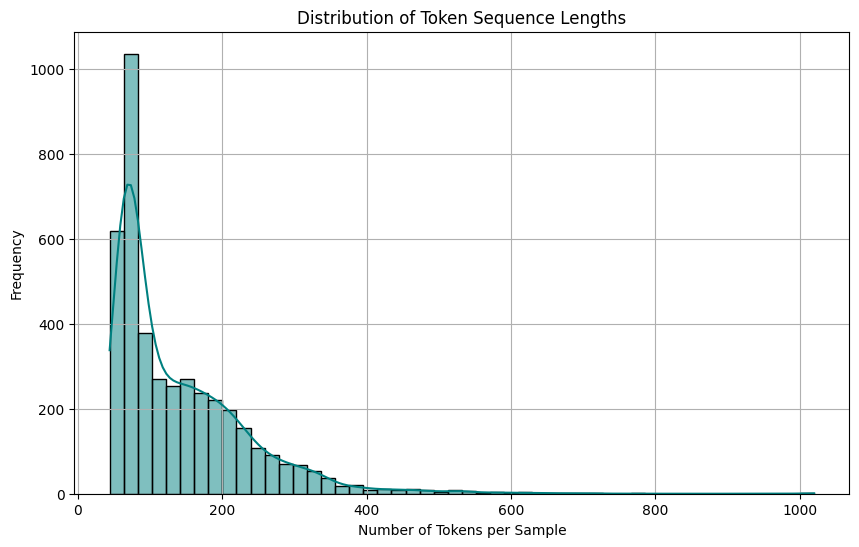

In [ ]:

# ⚠️ Replace with your dataset if needed
df = tokenized_dataset["validation"]  # assumes HuggingFace Dataset format

# 🧮 Collect token lengths
token_lengths = []
# Iterate over the 'df' variable which holds the dataset split, not the string 'dataset'
for example in tqdm(df, desc="Tokenizing samples"):
    text = example["text"]
    tokens = tokenizer(text, truncation=False)["input_ids"]
    token_lengths.append(len(tokens))

# 📊 Basic statistics
min_len = np.min(token_lengths)
max_len = np.max(token_lengths)
mean_len = np.mean(token_lengths)
p90 = np.percentile(token_lengths, 90)
p95 = np.percentile(token_lengths, 95)

print(f"🔢 Token Length Statistics:")
print(f"Min: {min_len} tokens")
print(f"Max: {max_len} tokens")
print(f"Mean: {mean_len:.2f} tokens")
print(f"90th Percentile: {p90:.0f} tokens")
print(f"95th Percentile: {p95:.0f} tokens")

# 📈 Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(token_lengths, bins=50, kde=True, color="teal")
plt.title("Distribution of Token Sequence Lengths")
plt.xlabel("Number of Tokens per Sample")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Setup Training Configuration

In [ ]:
!pip install transformers==4.51.3

# Train The Model

In [ ]:
# 7. Model Fine-Tuning (SFTTrainer setup)
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq, EarlyStoppingCallback
from unsloth import is_bfloat16_supported
from peft import LoraConfig

# 🔧 Sequence length optimized based on your dataset (most under 256)
MAX_LENGTH = 256

# 🧠 LoRA Configuration (with slightly higher dropout to reduce overfitting)
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
        "embed_tokens", "lm_head",
    ],
    bias="none",
    lora_dropout=0.1,  # 🔺 Improved generalization
    task_type="CAUSAL_LM",
)

# 🏋️ Training Arguments (optimized for A100 or L4 - 24GB VRAM)
training_args = TrainingArguments(
    per_device_train_batch_size=64,             # 🔺 Increased batch, no gradient accumulation
    gradient_accumulation_steps=1,              # 🔺 Fixes Unsloth warning
    warmup_steps=5,
    max_steps=1000,                             # 🔺 More steps to improve performance
    learning_rate=2e-5,
    fp16=False,                                 # LLaMA 3 is bfloat16-native
    bf16=True,
    logging_strategy="steps",
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    optim="adamw_8bit",
    weight_decay=0.01,
    lr_scheduler_type="linear",
    seed=3407,
    output_dir="outputs",
    report_to="none",
)

# 🧪 Final Trainer Setup
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    dataset_text_field="text",
    max_seq_length=MAX_LENGTH,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer),
    dataset_num_proc=2,
    packing=True,
    peft_config=lora_config,
    args=training_args,
)


In [ ]:
trainer.train()


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 182,822 | Num Epochs = 1 | Total steps = 1,000
O^O/ \_/ \    Batch size per device = 64 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (64 x 1 x 1) = 64
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss,Validation Loss
50,1.752900,1.666577
100,1.544200,1.583727
150,1.489000,1.575733
200,1.487800,1.572178
250,1.481600,1.568117
300,1.465500,1.565383
350,1.466400,1.562213
400,1.468100,1.563637
450,1.466400,1.560278
500,1.469400,1.557565


Unsloth: Will smartly offload gradients to save VRAM!


TrainOutput(global_step=1000, training_loss=1.480826072692871, metrics={'train_runtime': 6288.9019, 'train_samples_per_second': 10.177, 'train_steps_per_second': 0.159, 'total_flos': 7.41887283560448e+17, 'train_loss': 1.480826072692871})

# Evalution Model

In [ ]:
for entry in trainer.state.log_history:
    if "eval_loss" in entry:
        print(entry)


{'eval_loss': 1.6665765047073364, 'eval_runtime': 116.6237, 'eval_samples_per_second': 35.867, 'eval_steps_per_second': 4.485, 'epoch': 0.01750087504375219, 'step': 50}
{'eval_loss': 1.5837268829345703, 'eval_runtime': 113.6261, 'eval_samples_per_second': 36.814, 'eval_steps_per_second': 4.603, 'epoch': 0.03500175008750438, 'step': 100}
{'eval_loss': 1.5757334232330322, 'eval_runtime': 113.7234, 'eval_samples_per_second': 36.782, 'eval_steps_per_second': 4.599, 'epoch': 0.052502625131256565, 'step': 150}
{'eval_loss': 1.572177767753601, 'eval_runtime': 113.5366, 'eval_samples_per_second': 36.843, 'eval_steps_per_second': 4.606, 'epoch': 0.07000350017500875, 'step': 200}
{'eval_loss': 1.5681166648864746, 'eval_runtime': 113.5589, 'eval_samples_per_second': 36.836, 'eval_steps_per_second': 4.606, 'epoch': 0.08750437521876094, 'step': 250}
{'eval_loss': 1.565382719039917, 'eval_runtime': 113.5476, 'eval_samples_per_second': 36.839, 'eval_steps_per_second': 4.606, 'epoch': 0.10500525026251

## Visulization Evalution Model

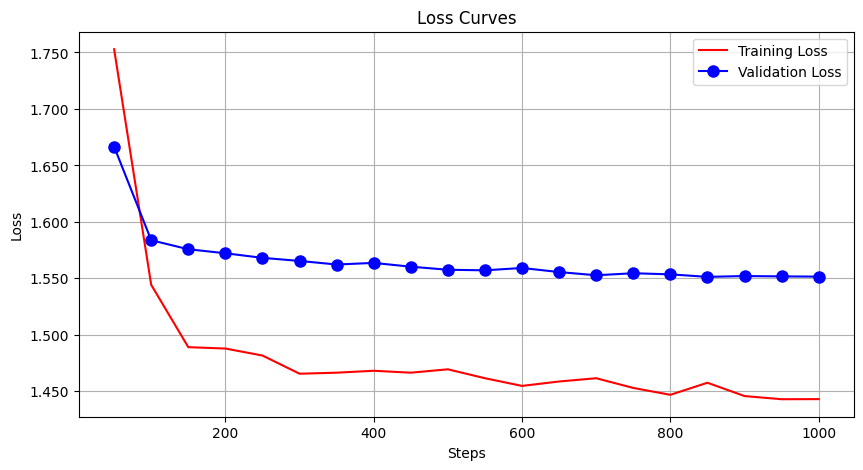

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Extract training and evaluation loss
logs = trainer.state.log_history
train_steps, train_loss = [], []
eval_steps, eval_loss = [], []

for entry in logs:
    if "loss" in entry and "step" in entry:
        train_steps.append(entry["step"])
        train_loss.append(entry["loss"])
    if "eval_loss" in entry and "step" in entry:
        eval_steps.append(entry["step"])
        eval_loss.append(entry["eval_loss"])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label="Training Loss", color="red")
plt.plot(eval_steps, eval_loss, label="Validation Loss", color="blue", marker="o", linestyle="-", markersize=8)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True)

# Format y-axis ticks to show 3 decimal places
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

plt.show()


# Saving The Model

## Logging in Huggingface

In [ ]:
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
model.save_pretrained("YOUR_MODEL")
tokenizer.save_pretrained("YOUR_MODEL")


('llama3-medmcqa-AmirKhier/tokenizer_config.json',
 'llama3-medmcqa-AmirKhier/special_tokens_map.json',
 'llama3-medmcqa-AmirKhier/tokenizer.json')

## Pushing to My Hugging Face Hub

In [ ]:
username = input("Enter Your Username : ")

Enter Your Username : Amir32432


In [ ]:
model.push_to_hub(f"{username}/MODEL")
tokenizer.push_to_hub(f"{username}/MODEL")


README.md:   0%|          | 0.00/614 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Saved model to https://huggingface.co/Amir32432/llama3-medmcqa-AmirKhier


  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

## Loading the model

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "YOUR_MODEL", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Describe a tall tower in the capital of France."},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


The description you're likely referring to is the Eiffel Tower, which stands in the heart of the capital of France: Paris.  The Eiffel Tower is a famous iron lattice tower that serves as a symbol of the city and France itself.  Here's a description:

The Eiffel Tower stands at an impressive height of 324 meters (1,063 feet) tall, making it one of the tallest structures in the world.  The tower has an octagonal shape and is comprised of four main pillars that meet at the top to form a platform.  The pillars are supported by a system of girders and


# Testing The model

In [ ]:
import torch

# Use the first N examples from your validation dataset
sample_prompts = dataset["test"][15:25]["question"]  # Adjust number as needed

# Generation settings
generation_args = {
    "max_new_tokens": 200,
    "do_sample": True,
    "temperature": 0.7,
    "top_p": 0.9,
    "top_k": 50
}

# Set model to evaluation mode
model.eval()

# Generate responses
for i, prompt in enumerate(sample_prompts, 1):
    print(f"\n--- Prompt {i} ---")
    print(f"📝 {prompt}\n")

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, **generation_args)

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"🤖 {response}\n")



--- Prompt 1 ---
📝 True of umbilical hernia -

🤖 True of umbilical hernia - a condition in which a part of the intestine protrudes through an opening in the abdominal wall, typically in infants. It's usually harmless and may not cause any symptoms. If symptoms do occur, they may include a visible bulge or lump in the navel area, pain or discomfort when the baby moves or coughs, and a feeling of the bulge getting bigger when the baby cries or strains.
In some cases, umbilical hernias may cause complications, such as bowel obstruction or strangulation, which can be serious and require immediate medical attention. Treatment for umbilical hernia in infants usually involves monitoring the condition, and in some cases, surgery may be necessary to repair the hernia.
In adults, umbilical hernias are more common and may be caused by various factors, such as obesity, pregnancy, or previous abdominal surgery. Symptoms may include a visible bulge or lump in the navel area, pain or discomfort, and

# Converting to GGUF for Ollama

In [ ]:
# Replace this with your HF token (get one from https://huggingface.co/settings/tokens)
HF_TOKEN = "YOUR_TOKEN"

# ✅ Save GGUF locally (quantized to q4_k_m)
model.save_pretrained_gguf(
    "YOURGGUF",  # Output folder for .gguf file(s)
    tokenizer,
    quantization_method="q4_k_m"
)

# ✅ Upload GGUF to your Hugging Face repo without overwriting your original model
model.push_to_hub_gguf(
    "YOUR_MODEL",  # Your existing HF repo
    tokenizer,
    quantization_method="q4_k_m",
    token=HF_TOKEN
)



Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 6.0G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 61.43 out of 83.48 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 32/32 [00:00<00:00, 45.44it/s]


Unsloth: Saving tokenizer... Done.
Done.


Unsloth: Converting llama model. Can use fast conversion = False.


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: CMAKE detected. Finalizing some steps for installation.
Unsloth: [1] Converting model at llama3-medmcqa-AmirKhier-gguf into bf16 GGUF format.
The output location will be /content/llama.cpp/llama3-medmcqa-AmirKhier-gguf/unsloth.BF16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: llama3-medmcqa-AmirKhier-gguf
INFO:hf-to-gguf:Model architecture: LlamaForCausalLM
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 --> F32, shape = {64}
INFO:hf-to-gguf:gguf

100%|██████████| 32/32 [00:00<00:00, 65.94it/s]


Unsloth: Saving tokenizer... Done.
Done.
==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: [1] Converting model at Amir32432/llama3-medmcqa-AmirKhier into bf16 GGUF format.
The output location will be /content/llama.cpp/Amir32432/llama3-medmcqa-AmirKhier/unsloth.BF16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: llama3-medmcqa-AmirKhier
INFO:hf-to-gguf:Model architecture: LlamaForCausalLM
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 --> F32, shape = {64}
INFO:hf-to-gguf:gguf: loading model wei

unsloth.Q4_K_M.gguf:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Saved GGUF to https://huggingface.co/Amir32432/llama3-medmcqa-AmirKhier


# WebUI Deployment

In [ ]:
!pip install open-webui

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 66.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.9